In [ ]:
import os
import yaml
import torch
from easydict import EasyDict
from interfaces.super_resolution import TextSR
from model.tsrn import TSRN
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

# device = torch.device("cpu")

args = argparse.Namespace()

args.arch = 'tsrn'
args.syn = False
args.mixed = False
args.mask = True
args.STN = True
args.gradient = True
args.srb = 5
args.hd_u = 32
args.resume = '/Users/jorgecamero/Downloads/model_best_dict.pth'
args.batch_size = 2
args.test_data_dir = ''
args.vis_dir = ''

config_path = os.path.join('config', 'super_resolution.yaml')
config = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)
config = EasyDict(config)
tsr = TextSR(config=config, args=args)

model = tsr.generator_init()['model']
model = model.to(device)
model.eval()

loading pre-trained model from /Users/jorgecamero/Downloads/model_best_dict.pth 


TSRN(
  (block1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): RecurrentResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gru1): GruBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gru): GRU(64, 32, batch_first=True, bidirectional=True)
    )
    (prelu): mish()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gru2): GruBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gru): GRU(64, 32, batch_first=True, bidirectional=True)
    )
  )
  (block3): RecurrentResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1

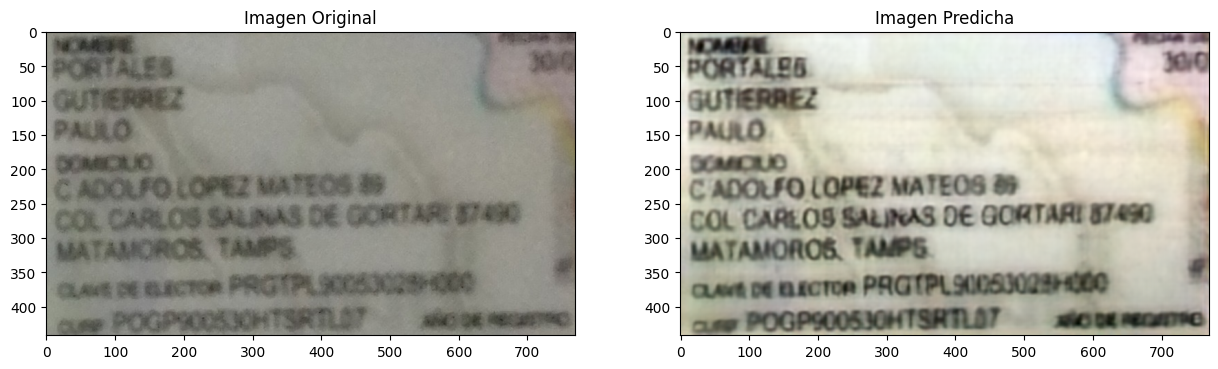

In [5]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import torch

class resizeNormalize(object):
    def __init__(self, size, mask=False, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.mask = mask

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img_tensor = self.toTensor(img)
        if self.mask:
            mask = img.convert('L')
            thres = np.array(mask).mean()
            mask = mask.point(lambda x: 0 if x > thres else 255)
            mask = self.toTensor(mask)
            img_tensor = torch.cat((img_tensor, mask), 0)
        return img_tensor

image_dir = '/Users/jorgecamero/MoireDataset/mergeDataset/Reales_crop'
image_list = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
image_path = random.choice(image_list)

image = Image.open(image_path).convert("RGB")
image = Image.open('/Users/jorgecamero/MoireDataset/test/0a52c4d3-7dc5-4557-8776-a241d7fae106_front.jpg').convert("RGB")
transform = resizeNormalize(size=(224, 128), mask=True)
input_tensor = transform(image).to(device).unsqueeze(0)

output = model(input_tensor)[0][:3, :, :]
output_np = output.cpu().detach().numpy()
output_np = np.transpose(output_np, (1, 2, 0))
output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())
output_np = (output_np * 255).astype(np.uint8)
output_image = Image.fromarray(output_np)
output_image = output_image.resize((image.size[0], image.size[1]))

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen Original")
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Imagen Predicha")
plt.axis('on')

plt.show()

In [9]:
traced_model = torch.jit.trace(model, input_tensor)

torch.jit.save(traced_model, "traced_model.pt")

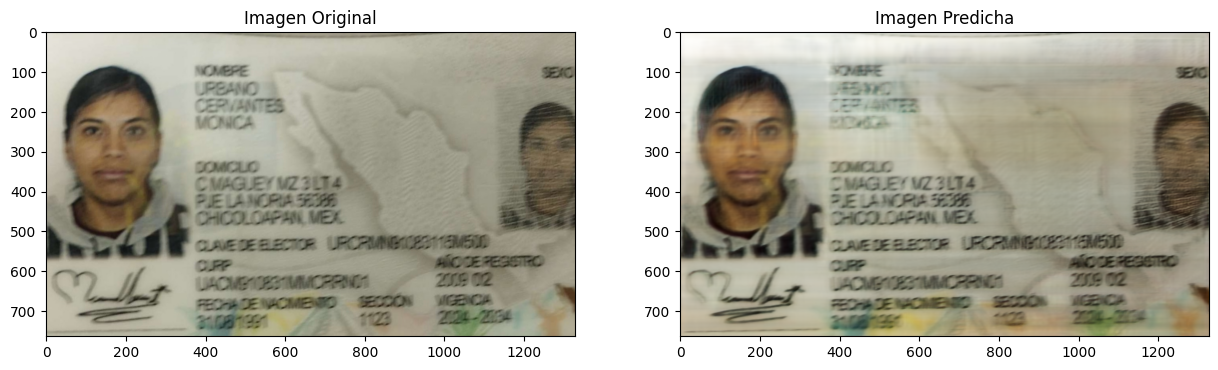

In [11]:
loaded_model = torch.jit.load("traced_model.pt")

output = model(input_tensor)[0][:3, :, :]
output_np = output.cpu().detach().numpy()
output_np = np.transpose(output_np, (1, 2, 0))
output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())
output_np = (output_np * 255).astype(np.uint8)
output_image = Image.fromarray(output_np)
output_image = output_image.resize((image.size[0], image.size[1])) 

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen Original")
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title("Imagen Predicha")
plt.axis('on')

plt.show()

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import argparse
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

class resizeNormalize(object):
    def __init__(self, size, mask=False, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.mask = mask

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img_tensor = self.toTensor(img)
        if self.mask:
            mask = img.convert('L')
            thres = np.array(mask).mean()
            mask = mask.point(lambda x: 0 if x > thres else 255)
            mask = self.toTensor(mask)
            img_tensor = torch.cat((img_tensor, mask), 0)
        return img_tensor
    
def main(args):
    image_path = args.image_path
    model = torch.jit.load("traced_model.pt", map_location=device)

    image = Image.open(image_path).convert("RGB")
    transform = resizeNormalize(size=(image.size[0], image.size[1]), mask=True)
    input_tensor = transform(image).to(device).unsqueeze(0)

    output = model(input_tensor)[0][:3, :, :]
    output_np = output.cpu().detach().numpy()
    output_np = np.transpose(output_np, (1, 2, 0))
    output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())
    output_np = (output_np * 255).astype(np.uint8)
    output_image = Image.fromarray(output_np)
    output_image = output_image.resize((image.size[0], image.size[1]))
    output_image.save(os.path.join(os.path.dirname(image_path), f"{os.path.basename(image_path).split('.')[0]}_predicted.jpg"))

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Process an image and save the output.")
    parser.add_argument("--image_path", type=str, help="Path to the input image", required=True)
    args = parser.parse_args()
    main(args)

Output saved at: /Users/jorgecamero/MoireDataset/test/0a52c4d3-7dc5-4557-8776-a241d7fae106_front_predicted.jpg


In [ ]:
import os
import yaml
import torch
from PIL import Image
from easydict import EasyDict
from interfaces.super_resolution import TextSR
from model.tsrn import TSRN
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

# device = torch.device("cpu")

args = argparse.Namespace()

args.arch = 'tsrn'
args.syn = False
args.mixed = False
args.mask = True
args.STN = True
args.gradient = True
args.srb = 5
args.hd_u = 32
args.resume = '/home/ec2-user/OCR/TextZoom/src/ckpt/vis/model_best_dict.pth'
args.batch_size = 2
args.test_data_dir = ''
args.vis_dir = ''

config_path = os.path.join('config', 'super_resolution.yaml')
config = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)
config = EasyDict(config)
tsr = TextSR(config=config, args=args)

model = tsr.generator_init()['model']
model = model.to(device)
model.eval()

class resizeNormalize(object):
    def __init__(self, size, mask=False, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.mask = mask

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img_tensor = self.toTensor(img)
        if self.mask:
            mask = img.convert('L')
            thres = np.array(mask).mean()
            mask = mask.point(lambda x: 0 if x > thres else 255)
            mask = self.toTensor(mask)
            img_tensor = torch.cat((img_tensor, mask), 0)
        return img_tensor
    
image = Image.open('/home/ec2-user/OCR/0a96d529-d8e1-407b-b329-e64ac5ad7015_front.jpg').convert("RGB")
transform = resizeNormalize(size=(224, 128), mask=True)
input_tensor = transform(image).to(device).unsqueeze(0)

traced_model = torch.jit.trace(model, input_tensor)

torch.jit.save(traced_model, "traced_model.pt")